In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv

import os
import sys
import copy
from tqdm import tqdm

# Add src to path
sys.path.append("src")
import kmeans
import utils

## Jupyter notebooks settings.

# Reload modules before executing each cell.
%load_ext autoreload
%autoreload 2 

# Introduction

## Theory and implementation

In this lab  we segment the given image using K-means clustering.

We cluster the pixels based on their values. I followed the algorithm taught in class.
Breifly, we initialize by randomly assigning cluster centers and then assig points to clusters. 
Then we recalculate the cluster center and this continues till there is not change in cluster indentity after an iteration.


## Code organization
**Data**: `data`

**Source code**: `src`
* `kmeans.py`: Functions related to K-mean clustering.
* `utils.py`: Various utility functions.
    * `get_pixel_array` \& `get_image`: Convert input image to an array of pixels and vice-versa. 
    * `plot_rgb`: Outputs 3D-scatter plot of pixels in an image along the RGB axis.

# Result

### Import data and visualize.

In [2]:
car = cv.imread('data/input/car.png')
car = cv.cvtColor(car, cv.COLOR_BGR2RGB)
flower = cv.imread('data/input/flower.png')
flower = cv.cvtColor(flower, cv.COLOR_BGR2RGB)
imgs = [car, flower]
img_names = ['car', 'flower']
c_init_1 = [[255, 0, 0], [0, 0, 0], [255, 255, 255]]

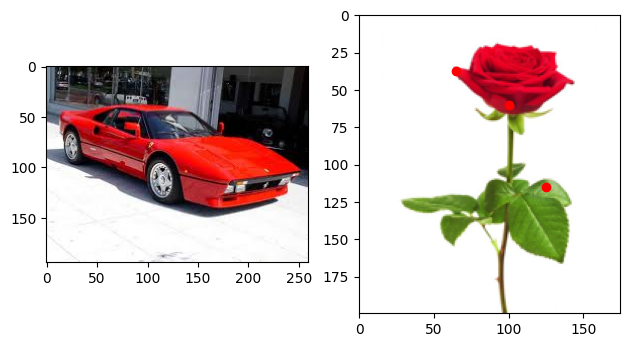

In [3]:
fig, axs = plt.subplots(1, 2)
axs[0].imshow(imgs[0])
axs[1].imshow(imgs[1])
axs[1].plot([65], [37], 'o', color='red')
axs[1].plot([100], [60], 'o', color='red')
axs[1].plot([125], [115], 'o', color='red')
fig.tight_layout()

In [4]:
# Examine pixel values at various position of the image.
print(flower[37, 65])
print(flower[60, 100])
print(flower[115, 125])

[236  26  49]
[166  14  38]
[125 168  76]


### Part-a: Cluster with given initial cluster centers.

In [5]:
# Segment image with in put cluster centers as initial  cluster centers.
imgs_segmented = []
for img in imgs:
    img_arr = utils.get_pixel_array(img)
    c_init = np.array([[255, 255, 255], [15, 50, 120], [100, 200, 100]]).T
    cluster_assignment, clusters, cost = kmeans.kmeans(img_arr, 3, c_init)
    for i in range(img_arr.shape[1]):
        img_arr[:, i] = clusters[:, cluster_assignment[i]]
    img_segmented = utils.get_image(img_arr, img.shape[0], img.shape[1])
    imgs_segmented.append(img_segmented)

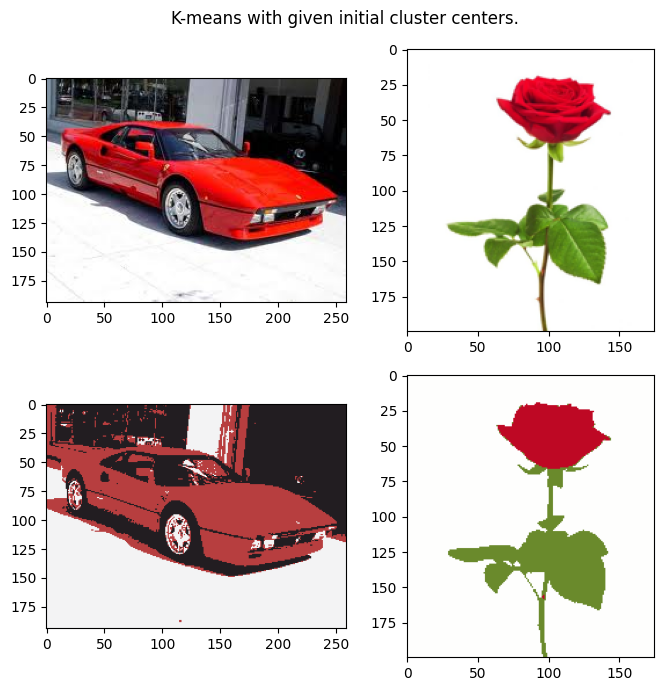

In [6]:
# Plot output
fig, axs = plt.subplots(2, 2, figsize=(7, 7))
axs[0, 0].imshow(imgs[0])
axs[0, 1].imshow(imgs[1])
axs[1, 0].imshow(imgs_segmented[0])
axs[1, 1].imshow(imgs_segmented[1])
fig.suptitle('K-means with given initial cluster centers.')
fig.tight_layout()
fig.savefig('data/output/output_a.png')

### Part-b: K-means by random initialization of the cluster centers.

In [7]:
min_imgs_segmented = []
max_imgs_segmented = []
costs_imgs = []
for img in imgs:
    mincost_cluster_assignment, mincost_clusters, mincost = [], [], np.inf
    maxcost_cluster_assignment, maxcost_clusters, maxcost = [], [], 0
    costs_img = []
    img_arr = utils.get_pixel_array(img)
    min_img_arr = copy.deepcopy(img_arr)
    max_img_arr = copy.deepcopy(img_arr)
    for i in tqdm(range(30)):
        cluster_assignment, clusters, cost = kmeans.kmeans(img_arr, 3)
        costs_img.append(cost)
        if cost <= mincost:
            mincost_cluster_assignment, mincost_clusters, mincost = cluster_assignment, clusters, cost
        if cost >= maxcost:
            # print(i)
            maxcost_cluster_assignment, maxcost_clusters, maxcost = cluster_assignment, clusters, cost

    for i in range(img_arr.shape[1]):
        min_img_arr[:, i] = mincost_clusters[:, mincost_cluster_assignment[i]]
        max_img_arr[:, i] = maxcost_clusters[:, maxcost_cluster_assignment[i]]
    costs_imgs.append(costs_img)
    min_img_segmented = utils.get_image(min_img_arr, img.shape[0], img.shape[1])
    max_img_segmented = utils.get_image(max_img_arr, img.shape[0], img.shape[1])
    min_imgs_segmented.append(min_img_segmented)
    max_imgs_segmented.append(max_img_segmented)

100%|██████████| 30/30 [02:01<00:00,  4.05s/it]


In [8]:
maxcost_cluster_assignment.shape

(35000,)

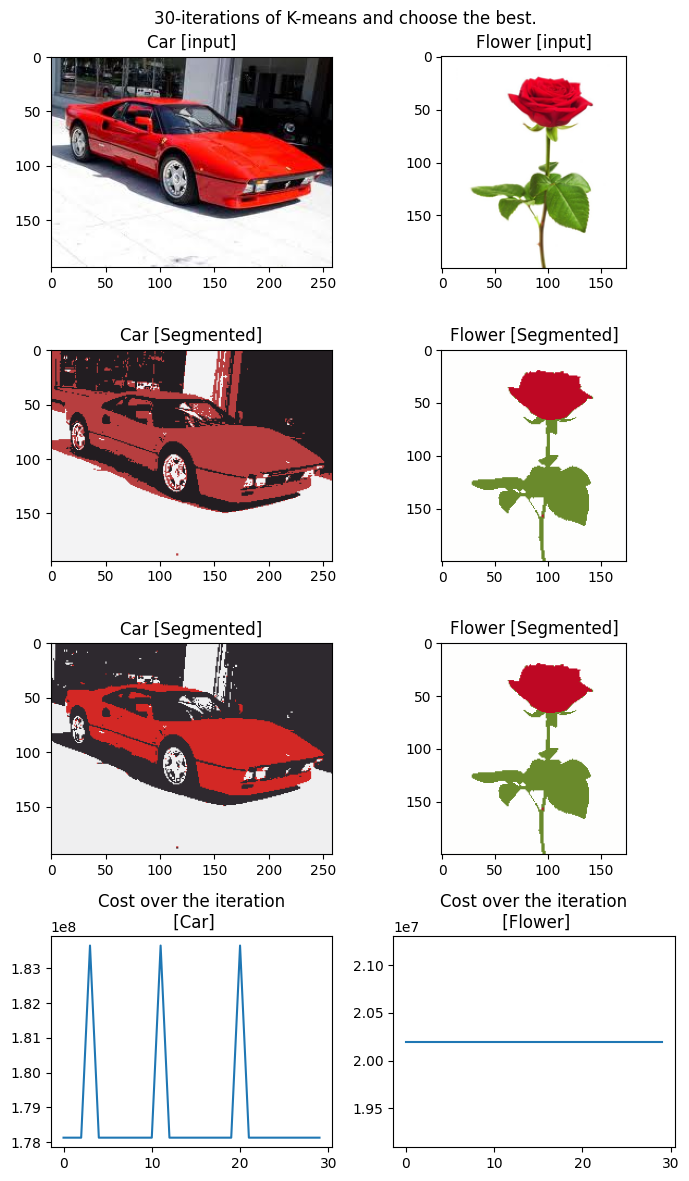

In [9]:
fig, axs = plt.subplots(4, 2, figsize=(7, 12))
axs[0, 0].imshow(imgs[0])
axs[0, 0].set_title('Car [input]')
axs[0, 1].imshow(imgs[1])
axs[0, 1].set_title('Flower [input]')

axs[1, 0].imshow(min_imgs_segmented[0])
axs[1, 0].set_title('Car [Segmented]')
axs[1, 1].imshow(min_imgs_segmented[1])
axs[1, 1].set_title('Flower [Segmented]')

axs[2, 0].imshow(max_imgs_segmented[0])
axs[2, 0].set_title('Car [Segmented]')
axs[2, 1].imshow(max_imgs_segmented[1])
axs[2, 1].set_title('Flower [Segmented]')

axs[3, 0].plot([i for i in range(30)], costs_imgs[0])
axs[3, 0].set_title('Cost over the iteration\n [Car]')
axs[3, 1].plot([i for i in range(30)], costs_imgs[1])
axs[3, 1].set_title('Cost over the iteration\n [Flower]')
# axs[3, 1].set_xlim(2e7, 2.1e7)

fig.suptitle('30-iterations of K-means and choose the best.')
fig.tight_layout()
fig.savefig('data/output_b.png')

# Discussion

From the above plot it is clear that the clustering did not work well for `flower`. I think it is because the clustering happened more on the line of the brightness rather than color. I think this is also true for `car`. To further understand this issue I plot the pixel values on the 3D plot along RGB axis.

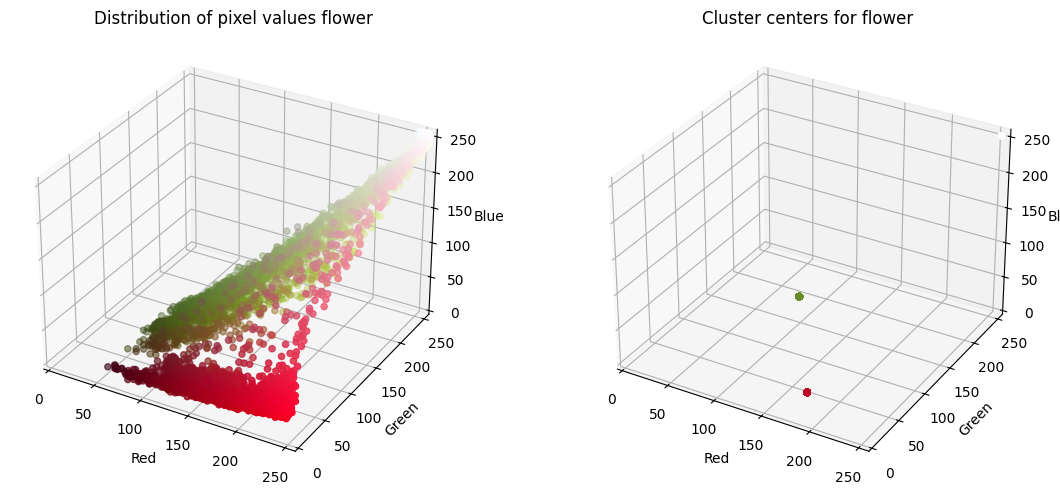

In [10]:
# 3D plot of pixel values and cluster center for 'Flower'.
fig, axs = plt.subplots(1, 2, figsize=(12, 5), subplot_kw={'projection': '3d'})
utils.plot_rgb(axs[0], flower, title='Distribution of pixel values flower')
utils.plot_rgb(axs[1], imgs_segmented[1], title='Cluster centers for flower')
fig.tight_layout()

We can see that while there are two clear clusters of blue and green (The white cluster is concentrated at the white pixel), there is also a significant overlap between these two clusters. Therefore we can see that many "green" pixels are closer to the "blue" cluster center than to the green cluster center and vice-versa.
